In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
!pip install konlpy
!pip install mecab-python
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 29.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 16.5 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1230 sha256=50ac1a460424320af2b2a0bd2452183a2f973948b82bee3be226540b07209ec2
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python


# 1. 데이터 불러오기 및 전처리

In [3]:
# 네이버, 창원대가 함께하는 NLP Challenge 의 훈련용 데이터
# https://github.com/naver/nlp-challenge/?tab=readme-ov-file
!wget https://github.com/naver/nlp-challenge/raw/master/missions/ner/data/train/train_data

--2024-08-10 11:48:14--  https://github.com/naver/nlp-challenge/raw/master/missions/ner/data/train/train_data
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/naver/nlp-challenge/master/missions/ner/data/train/train_data [following]
--2024-08-10 11:48:14--  https://raw.githubusercontent.com/naver/nlp-challenge/master/missions/ner/data/train/train_data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16945023 (16M) [application/octet-stream]
Saving to: ‘train_data’

train_data          100%[===================>]  16.16M  --.-KB/s    in 0.06s   

2024-08-10 11:48:15 (256 MB/s) - ‘train_data’ saved [

https://air.changwon.ac.kr/?page_id=10

In [4]:
data_pd = pd.read_csv("train_data", names = ['text', 'tag'], sep = "\t")
data_pd.reset_index(inplace=True) # 어절번호 데이터 살려오려구
# 첫번째 열 : 어절번호
# 두번째 열 : 어절
# 세번째 열 : 개체명 레이블
data_pd.sample(6)

,index,text,tag
83200,6,기졸이,-
178587,4,알린,-
544324,5,2월이나,DAT_B
679461,14,것으로,-
13323,35,방자가,-
516933,4,4년,DAT_B


In [5]:
# 전체 데이터 개수 확인
print(f"전체 문장 조각 개수는 {len(data_pd)}개입니다.")

전체 문장 조각 개수는 769065개입니다.


In [6]:
print(data_pd.dtypes)
data_pd['text'] = data_pd['text'].astype(str) # 혹시 몰라서 한 번 더 명시
data_pd['tag'] = data_pd['tag'].astype(str)

index     int64
text     object
tag      object
dtype: object


In [7]:
pattern = r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]"
def clean(text):
  return re.sub(pattern,"",text)
data_pd['text'] = data_pd['text'].apply(clean)
data_pd[40:50]

,index,text,tag
40,10,,-
41,1,,-
42,2,퍼거슨,PER_B
43,3,씨족의,CVL_B
44,4,꾀,-
45,1,유로2008,EVT_B
46,2,공인구가,CVL_B
47,3,변할,-
48,4,기록,-
49,5,시정조치는,CVL_B


# 2. [index, text, tag]의 형식을 갖도록 데이터 분리

In [8]:
array = data_pd.to_numpy() # array로 만들어주고
data = [list(x) for x in array]
data[:5]

[[1, '비토리오', 'PER_B'],
 [2, '양일', 'DAT_B'],
 [3, '만에', '-'],
 [4, '영사관', 'ORG_B'],
 [5, '감호', 'CVL_B']]

In [9]:
# 첫 문장 + 다음 문장 첫 단어
data[:11]

[[1, '비토리오', 'PER_B'],
 [2, '양일', 'DAT_B'],
 [3, '만에', '-'],
 [4, '영사관', 'ORG_B'],
 [5, '감호', 'CVL_B'],
 [6, '용퇴', '-'],
 [7, '항룡', '-'],
 [8, '압력설', '-'],
 [9, '의심만', '-'],
 [10, '가율', '-'],
 [1, '이', '-']]

# 2. 고유한 tag 모아서 label 리스트에 모아두기, tag_size 구하기

In [10]:
label = data_pd['tag'].unique().tolist()
index_to_tag = {0:"[PAD]"}
index_to_tag.update({i+1 : tag for i,tag in enumerate(label)})
print(index_to_tag) # 총 30개의 고유한 tag 존재

{0: '[PAD]', 1: 'PER_B', 2: 'DAT_B', 3: '-', 4: 'ORG_B', 5: 'CVL_B', 6: 'NUM_B', 7: 'LOC_B', 8: 'EVT_B', 9: 'TRM_B', 10: 'TRM_I', 11: 'EVT_I', 12: 'PER_I', 13: 'CVL_I', 14: 'NUM_I', 15: 'TIM_B', 16: 'TIM_I', 17: 'ORG_I', 18: 'DAT_I', 19: 'ANM_B', 20: 'MAT_B', 21: 'MAT_I', 22: 'AFW_B', 23: 'FLD_B', 24: 'LOC_I', 25: 'AFW_I', 26: 'PLT_B', 27: 'FLD_I', 28: 'ANM_I', 29: 'PLT_I'}


In [11]:
tag_size = len(index_to_tag)
tag_size

30

In [12]:
tag_to_index = {i:j for j,i in index_to_tag.items()}
print(tag_to_index)

{'[PAD]': 0, 'PER_B': 1, 'DAT_B': 2, '-': 3, 'ORG_B': 4, 'CVL_B': 5, 'NUM_B': 6, 'LOC_B': 7, 'EVT_B': 8, 'TRM_B': 9, 'TRM_I': 10, 'EVT_I': 11, 'PER_I': 12, 'CVL_I': 13, 'NUM_I': 14, 'TIM_B': 15, 'TIM_I': 16, 'ORG_I': 17, 'DAT_I': 18, 'ANM_B': 19, 'MAT_B': 20, 'MAT_I': 21, 'AFW_B': 22, 'FLD_B': 23, 'LOC_I': 24, 'AFW_I': 25, 'PLT_B': 26, 'FLD_I': 27, 'ANM_I': 28, 'PLT_I': 29}


# 3. 문장 분리
- 문장 단위로 끊어서 original_sentences에 저장
- 그 뒤에는 각 문장 앞 뒤로 [CLS]와 [SEP]을 넣은 뒤
  - text만 모아서 texts에
  - tag만 모아서 tags에
  - tag의 index들 모아서 tags_index에
  - text & tag 모아서 tts에

In [13]:
original_sentences = []
temporary = []

# 일단 문장을 temporary에 저장해두고 i=1이 되면 그동안 모은 걸 싹 넣어버려야지
# i=1 & temporary에 문장이 있다면 sentences에 append하고, temporary를 리셋해
# 그게 아니라면 temporary에 계속 append

for i, j, k in data:
  if i == 1 and temporary: # 1이고, temporary에 문장이 들어있다면 (전 문장이겠지)
    original_sentences.append(temporary)
    temporary = []
  temporary.append([i,j,k])

if temporary: # 마지막 문장 추가
  original_sentences.append(temporary)

original_sentences[0] # 성공이닷

[[1, '비토리오', 'PER_B'],
 [2, '양일', 'DAT_B'],
 [3, '만에', '-'],
 [4, '영사관', 'ORG_B'],
 [5, '감호', 'CVL_B'],
 [6, '용퇴', '-'],
 [7, '항룡', '-'],
 [8, '압력설', '-'],
 [9, '의심만', '-'],
 [10, '가율', '-']]

In [14]:
texts = []
tags = []
tags_index = []
tts = []

for sentence in original_sentences:
  text = ['[CLS]'] + [item[1] for item in sentence] +['[SEP]']
  tag = ['-'] + [item[2] for item in sentence] + ['-']
  texts.append(text)
  tags.append(tag)
  tags_index.append([tag_to_index[t] for t in tag])
  together = [[txt,tag_to_index[tg]] for txt,tg in zip(text, tag)]
  tts.append(together)

print(f"첫 문장은 {texts[0]}이고")
print(f"태깅을 진행하면 {tags[0]}가 됩니당")
print(f"태그를 index로 변환하면 {tags_index[0]}이에요!")
print(f"모아서 보면 {tts[0]} 이렇게 돼요!")

첫 문장은 ['[CLS]', '비토리오', '양일', '만에', '영사관', '감호', '용퇴', '항룡', '압력설', '의심만', '가율', '[SEP]']이고
태깅을 진행하면 ['-', 'PER_B', 'DAT_B', '-', 'ORG_B', 'CVL_B', '-', '-', '-', '-', '-', '-']가 됩니당
태그를 index로 변환하면 [3, 1, 2, 3, 4, 5, 3, 3, 3, 3, 3, 3]이에요!
모아서 보면 [['[CLS]', 3], ['비토리오', 1], ['양일', 2], ['만에', 3], ['영사관', 4], ['감호', 5], ['용퇴', 3], ['항룡', 3], ['압력설', 3], ['의심만', 3], ['가율', 3], ['[SEP]', 3]] 이렇게 돼요!


# 4. 토큰화 진행 - BERT 사용

In [15]:
!pip install transformers

In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [17]:
tokenizer.tokenize("나도 코딩 잘하고싶어")

['나', '##도', '코', '##딩', '잘', '##하고', '##싶', '##어']

In [18]:
# 첫 문장으로 시도
tts1 = tts[0]
print(tts1)

token_word1 = []
token_tag1 = []

for word, tag in tts1:
  token = tokenizer.tokenize(word)
  token_word1.append(token)
  temp = np.repeat(tag, len(token)).tolist()
  token_tag1.append(temp)

token_word1 = [item for items in token_word1 for item in items]
# token_tag1 = [[item] for item in items for items in token_tag1] # 얘는 틀려! items를 정의하기 전에 사용해서
token_tag1 = [item for items in token_tag1 for item in items]

print(token_word1)
print(token_tag1)

[['[CLS]', 3], ['비토리오', 1], ['양일', 2], ['만에', 3], ['영사관', 4], ['감호', 5], ['용퇴', 3], ['항룡', 3], ['압력설', 3], ['의심만', 3], ['가율', 3], ['[SEP]', 3]]
['[CLS]', '비', '##토', '##리', '##오', '양', '##일', '만', '##에', '영', '##사', '##관', '감', '##호', '용', '##퇴', '항', '##룡', '압', '##력', '##설', '의', '##심', '##만', '가', '##율', '[SEP]']
[3, 1, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [19]:
token_word = []
token_tag = []
tokenized_sentences = []
tokenized_tags = []

for sentence in tts:
  for word, tag in sentence:
    token = tokenizer.tokenize(word)
    token_word.append(token)
    temp = np.repeat(tag, len(token)).tolist()
    token_tag.append(temp)

  token_word = [item for items in token_word for item in items]
  token_tag = [item for items in token_tag for item in items]

  tokenized_sentences.append(token_word)
  tokenized_tags.append(token_tag)

  token_word = []
  token_tag = []

print(tokenized_sentences[1])
print(tokenized_tags[1])

['[CLS]', '이', '음', '##경', '##동', '##맥', '##의', '직', '##경', '##이', '8', '19', '##mm', '##입', '##니다', '[SEP]']
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 3]


# 5. 패딩 진행 & 문자 -> 정수로

- 패딩 길이 정하기

In [20]:
print(f"총 문장 개수는 {len(tokenized_sentences)}개입니다.") # 이게 총 문장 개수
print(f"가장 긴 문장의 길이는 {max(len(sent) for sent in tokenized_sentences)}이네요")
print("문장의 평균 길이는 {:.2f}이네요".format(sum(len(sent) for sent in tokenized_sentences)/len(tokenized_sentences)))

총 문장 개수는 65521개입니다.
가장 긴 문장의 길이는 555이네요
문장의 평균 길이는 33.04이네요


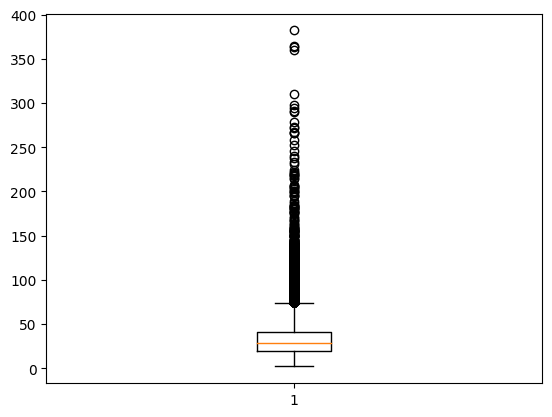

In [21]:
import matplotlib.pyplot as plt
length = [len(sent) for sent in tokenized_sentences if len(sent) < 400]

plt.boxplot(length)
plt.show()

In [22]:
max_length = 70

def below_threshold(max_length, text):
  num = 0
  for sent in text:
    if(len(sent) <= max_length):
      num += 1
  print("길이가 {} 이하인 문장의 비율은: {:.5f}".format(max_length,(num/len(text))))

below_threshold(max_length, tokenized_sentences)

길이가 70 이하인 문장의 비율은: 0.94414


- 일단은 90으로 진행 !

In [23]:
# 문자 -> 숫자로
texts = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_sentences]
tags = tokenized_tags

In [24]:
# 패딩 토큰 -> 0으로 변환됨
tokenizer.convert_tokens_to_ids(['[PAD]'])

[0]

In [25]:
input_texts = pad_sequences(texts, maxlen = max_length, dtype = 'int',
                            value = 0, truncating = 'post', padding = 'post')

In [26]:
input_tags = pad_sequences(tags, maxlen = max_length, dtype = 'int',
                           value = tag_to_index['[PAD]'], truncating = 'post', padding = 'post')

In [27]:
attention_masks = []
for sent in input_texts:
  mask = [1 if tok > 0 else 0 for tok in sent]
  attention_masks.append(mask)

# 6. train/test + validation set 나누기

In [28]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_tags, val_tags = train_test_split(input_texts, input_tags,
                                                                test_size = 0.1, random_state = 1108)

train_masks, val_masks, _, _ = train_test_split(attention_masks, input_texts,
                                                test_size = 0.1, random_state = 1108)

# 7. PyTorch로 변환 + 데이터 로더 만들기

In [29]:
train_texts = torch.tensor(train_texts)
val_texts = torch.tensor(val_texts)

train_tags = torch.tensor(train_tags)
val_tags = torch.tensor(val_tags)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 100 #################################

train_data = TensorDataset(train_texts, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_texts, val_masks, val_tags)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# 8. 모델 만들기

In [32]:
from transformers import BertForTokenClassification, AdamW, BertConfig

model = BertForTokenClassification.from_pretrained( # pertrained 된 모델을 데려와
    'bert-base-multilingual-cased', # 토크나이저 어떤 거
    num_labels = tag_size, # 몇 개로 분류할 건지
)

# model.cpu()
model.cuda()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [ ]:
# 모델 파라미터 개수.. 필수인가?

# 9. Optimizer & Learning Rate Scheduler

In [33]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
from transformers import get_linear_schedule_with_warmup

epochs = 1 ############################################

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 10. Training Loop

In [35]:
import numpy as np

# 정답 레이블, 예측 레이블을 각각 구해서 두 개가 일치하는 비율 계산

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=2).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime

# 시간이 얼마나 걸리는지 체크

def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds = elapsed_rounded))

In [37]:
import random

seed = 1008

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 디바이스로 이동
model.to(device)

loss_values = []

for epoch in range(epochs):

  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
  print('Training...')

  t0 = time.time()
  total_loss = 0 # reset loss

  # Train Mode
  model.train()

  # data 입력하기
  for step, batch in enumerate(train_dataloader):
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print('   Batch {:>5,}  of  {:>5,}.     Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    # GPU에 로드 (그치만 코랩 사용량 제한으로 GPU를 쓸 수 없어..)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # gradient 초기화
    model.zero_grad()

    # Forward Pass (순전파)
    outputs = model(b_input_ids,
                    token_type_ids = None,
                    attention_mask = b_input_mask,
                    labels = b_labels)

    loss = outputs.loss ################################

    total_loss += loss.item() # 값만 추출

    # Backward Pass (역전파)
    loss.backward()

    ################################
    torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)

    # 매개변수 update
    optimizer.step()

    # learning rate update
    scheduler.step()

  # average loss
  avg_train_loss = total_loss / len(train_dataloader)

  # 모든 loss 모아두기
  loss_values.append(avg_train_loss)

  print("")
  print(" Average training loss: {0:.2f}".format(avg_train_loss))
  print(" Training epoch took: {}".format(format_time(time.time() - t0)))

  # ------------------ Val ------------------------

  print("")
  print("Running Validation...")

  t0 = time.time()

  # Evaluation Mode
  model.eval()

  # Reset variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0 # (nb : number)

  for batch in val_dataloader:

    # GPU로 로드
    batch = tuple(t.to(device) for t in batch)

    # unpack
    b_input_ids, b_input_mask, b_labels = batch

    # grad 매번 지우면서 진행해
    with torch.no_grad():

      # Forward Pass
      outputs = model(b_input_ids,
                      token_type_ids = None,
                      attention_mask = b_input_mask)

    # Logit들 가져와
    logits = outputs.logits ###############################

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 이번 batch의 accuracy 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Total accuracy
    eval_accuracy += tmp_eval_accuracy

    # 몇 번째 batch인지
    nb_eval_steps += 1

  print(" Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps)) # 평균 accuracy
  print(" Validation took: {}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")




======== Epoch 1 / 1 ========
Training...


<ipython-input-37-e0b71656c942>:59: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


   Batch    40  of    590.     Elapsed: 0:00:45.
   Batch    80  of    590.     Elapsed: 0:01:35.
   Batch   120  of    590.     Elapsed: 0:02:24.
   Batch   160  of    590.     Elapsed: 0:03:13.
   Batch   200  of    590.     Elapsed: 0:04:02.
   Batch   240  of    590.     Elapsed: 0:04:51.
   Batch   280  of    590.     Elapsed: 0:05:41.
   Batch   320  of    590.     Elapsed: 0:06:30.
   Batch   360  of    590.     Elapsed: 0:07:19.
   Batch   400  of    590.     Elapsed: 0:08:08.
   Batch   440  of    590.     Elapsed: 0:08:57.
   Batch   480  of    590.     Elapsed: 0:09:47.
   Batch   520  of    590.     Elapsed: 0:10:36.
   Batch   560  of    590.     Elapsed: 0:11:25.

 Average training loss: 0.34
 Training epoch took: 0:12:02

Running Validation...
 Accuracy: 0.94
 Validation took: 0:00:27

Training complete!


Average training loss 0.17 -> 0.16 -> 0.15

Accuracy는 여전히 0.95...

총 걸린 시간 얼추 30분..?

시간을 위해 epoch를 일단 1번만..

In [38]:
def ner_pii_assign(sentence, model, tokenizer, index_to_tag, max_length, device):

  # 토크나이즈
  tokenized_sentence = tokenizer.tokenize(sentence)
  # 문자 -> 숫자로
  sent_in_num = tokenizer.convert_tokens_to_ids(tokenized_sentence)
  # 패딩
  input_sentence = pad_sequences([sent_in_num], maxlen = max_length, dtype = 'int',
                                  value = 0, truncating = 'post', padding = 'post')
  # 마스크
  input_mask = [[1 if tok > 0 else 0 for tok in sent] for sent in input_sentence]

  # Tensor로 변환
  input_sentence = torch.tensor(input_sentence).to(device)
  input_mask = torch.tensor(input_mask).to(device)

  # 입력
  with torch.no_grad():
    output = model(input_sentence, attention_mask = input_mask)
    logits = output.logits
  # 결과 출력
  pred = np.argmax(logits.cpu().numpy(), axis = 2)

  # 숫자 -> 문자
  tokens = tokenizer.convert_ids_to_tokens(input_sentence[0])

  out_tokens, out_labels = [], []

  for token, tag_index in zip(tokens, pred[0]):
    if (token.startswith('##')):
      out_labels.append(index_to_tag[tag_index])
      out_tokens.append(token[2:])
    elif (token in ['[CLS]', '[PAD]', '[SEP]']):
      pass
    else:
      out_tokens.append(token)
      out_labels.append(index_to_tag[tag_index])

  for token, label in zip(out_tokens, out_labels):
    print("{} \t {}".format(token,label))

In [39]:
ner_pii_assign("문재인 대통령은 1953년 1월 24일 경상남도 거제시에서 아버지 문용형과 어머니 강한옥 사이에서 둘째(장남)로 태어났다.", model, tokenizer, index_to_tag, max_length, device)

문 	 -
재 	 PER_B
인 	 PER_B
대통령 	 CVL_B
은 	 CVL_B
1953 	 DAT_B
년 	 DAT_B
1월 	 DAT_I
24일 	 DAT_I
경 	 LOC_B
상 	 LOC_B
남도 	 LOC_B
거 	 LOC_B
제 	 LOC_B
시 	 LOC_B
에서 	 LOC_B
아버지 	 PER_B
문 	 PER_B
용 	 PER_B
형 	 PER_B
과 	 PER_B
어머니 	 -
강 	 PER_B
한 	 PER_B
옥 	 PER_B
사이에 	 -
서 	 -
둘 	 NUM_B
째 	 NUM_B
( 	 -
장 	 CVL_B
남 	 CVL_B
) 	 -
로 	 -
태어났다 	 -
. 	 -


In [40]:
def ner_pii_masking(sentence, model, tokenizer, index_to_tag, max_length, device):

  # 토크나이즈
  tokenized_sentence = tokenizer.tokenize(sentence)
  # 문자 -> 숫자로
  sent_in_num = tokenizer.convert_tokens_to_ids(tokenized_sentence)
  # 패딩
  input_sentence = pad_sequences([sent_in_num], maxlen = max_length, dtype = 'int',
                                  value = 0, truncating = 'post', padding = 'post')
  # 마스크
  input_mask = [[1 if tok > 0 else 0 for tok in sent] for sent in input_sentence]

  # Tensor로 변환
  input_sentence = torch.tensor(input_sentence).to(device)
  input_mask = torch.tensor(input_mask).to(device)

  # 입력
  with torch.no_grad():
    output = model(input_sentence, attention_mask = input_mask)
    logits = output.logits
  # 결과 출력
  pred = np.argmax(logits.cpu().numpy(), axis = 2)

  # 숫자 -> 문자
  tokens = tokenizer.convert_ids_to_tokens(input_sentence[0])

  out_sentence = []
  current_token = ""

  for token, tag_index in zip(tokens, pred[0]):
    if (token in ['[CLS]', '[PAD]', '[SEP]']):
      pass
    elif (tag_index == 3): # '-', 즉 마스킹이 필요없는 친구라면
      if token.startswith("##"): # 앞이랑 이어지는 거면
        current_token += (token[2:]) # 붙여서

      else: # 이어지는 게 아니라면
        out_sentence.append(current_token)
        current_token = ""
        current_token += (token)


    else: # 마스킹이 필요한 애들이라면
      if token.startswith("##"):
        current_token += (f"[MASK-{index_to_tag[tag_index]}]")

      else:
        out_sentence.append(current_token)
        current_token = ""
        current_token += (f"[MASK-{index_to_tag[tag_index]}]")

  out_sentence.append(current_token)

  out_sentence = ' '.join(out_sentence)

  print(out_sentence)

In [41]:
ner_pii_masking("문재인 대통령은 1953년 1월 24일 경상남도 거제시에서 아버지 문용형과 어머니 강한옥 사이에서 둘째(장남)로 태어났다.", model, tokenizer, index_to_tag, max_length, device)

 문[MASK-PER_B][MASK-PER_B] [MASK-CVL_B][MASK-CVL_B] [MASK-DAT_B][MASK-DAT_B] [MASK-DAT_I] [MASK-DAT_I] [MASK-LOC_B][MASK-LOC_B][MASK-LOC_B] [MASK-LOC_B][MASK-LOC_B][MASK-LOC_B][MASK-LOC_B] [MASK-PER_B] [MASK-PER_B][MASK-PER_B][MASK-PER_B][MASK-PER_B] 어머니 [MASK-PER_B][MASK-PER_B][MASK-PER_B] 사이에서 [MASK-NUM_B][MASK-NUM_B] ( [MASK-CVL_B][MASK-CVL_B] ) 로 태어났다 .
